Option Basics, BSM model: Assignment 1

In [ ]:
# Collection of imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
from typing import Dict, List, Union
import numpy as np
from scipy.stats import norm
from scipy.special import erf
from itertools import product

a.) Smart up our plotter to be able to customize the hard-coded layout setup inside the function. Add more custom features that you would like to use

In [16]:
def my_smart_plotter(
    x: List[float],
    y: Union[List[float], List[List[float]]],
    layout: Dict = None,
    names: List[str] = None,
    colors: List[str] = None,
    linestyles: List[str] = None
):
    '''Necessary parameters:
    x: List of x values (float)
    y: List of y values (float) or List of Lists of y values (List[float])
    layout: Dictionary with layout settings (figsize, linewidth, title, x_label, y_label, xlim, ylim, grid, hline, vline, save_path)
    names: List of names for each y series (optional)
    colors: List of colors for each y series (optional)
    linestyles: List of linestyles for each y series (optional)
    '''
    y = [y] if all(isinstance(item, float) for item in y) else y
    num_lines = len(y)

    # --- Defaults ---
    default_layout = {
        'figsize': (8, 4),
        'linewidth': 3,
        'title_fontsize': 20,
        'label_fontsize': 16,
        'tick_fontsize': 14,
        'legend_fontsize': 14,
        'titlepad': 25,
        'labelpad': 15,
        'grid': False,
    }
    layout = {**default_layout, **(layout or {})}

    default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                      'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                      'tab:olive', 'tab:cyan']
    default_linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

    colors = colors if colors is not None else [default_colors[i % len(default_colors)] for i in range(num_lines)]
    linestyles = linestyles if linestyles is not None else [default_linestyles[i % len(default_linestyles)] for i in range(num_lines)]

    # Looking for errors in the input
    if names and len(names) != num_lines:
        raise ValueError("Length of 'names' must match length of y series.")
    if len(colors) != num_lines:
        raise ValueError("Length of 'colors' must match length of y series.")
    if len(linestyles) != num_lines:
        raise ValueError("Length of 'linestyles' must match length of y series.")

    # Plotting
    plt.figure(figsize=layout['figsize'])
    for i, y_item in enumerate(y):
        kwargs = {
            'linewidth': layout['linewidth'],
            'linestyle': linestyles[i],
            'color': colors[i]
        }
        if names:
            kwargs['label'] = names[i]
        plt.plot(x, y_item, **kwargs)

    # Labels and title
    if 'title' in layout:
        plt.title(layout['title'], fontsize=layout['title_fontsize'])
        rcParams['axes.titlepad'] = layout['titlepad']
    if 'x_label' in layout:
        plt.xlabel(layout['x_label'], fontsize=layout['label_fontsize'])
        rcParams['axes.labelpad'] = layout['labelpad']
    if 'y_label' in layout:
        plt.ylabel(layout['y_label'], fontsize=layout['label_fontsize'])

    # Limits
    if 'xlim' in layout:
        plt.xlim(layout['xlim'])
    if 'ylim' in layout:
        plt.ylim(layout['ylim'])

    # Grid and ticks
    if layout.get('grid', False):
        plt.grid(True)

    ax = plt.gca()
    ax.tick_params(labelsize=layout['tick_fontsize'])

    if layout.get('hline') is not None:
        ax.axhline(y=layout['hline'], linestyle='--', color='black', linewidth=1)
    if layout.get('vline') is not None:
        ax.axvline(x=layout['vline'], linestyle='--', color='black', linewidth=1)

    if names:
        plt.legend(fontsize=layout['legend_fontsize'])

    if 'save_path' in layout:
        plt.savefig(layout['save_path'], dpi=layout.get('dpi', 300), bbox_inches='tight')

    plt.show()

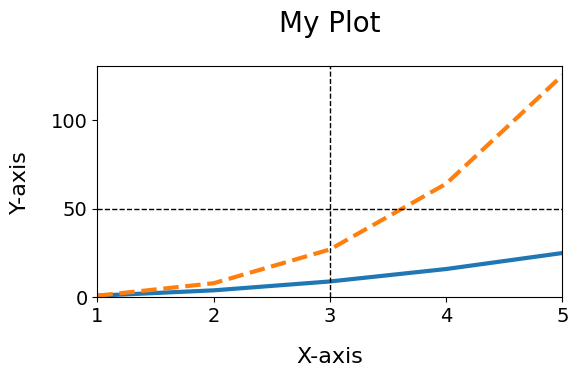

In [17]:
# Example usage
if __name__ == "__main__":
    x = [1, 2, 3, 4, 5]
    y1 = [1, 4, 9, 16, 25]
    y2 = [1, 8, 27, 64, 125]
    layout = {
        'figsize': (6, 3),
        'title': 'My Plot',
        'x_label': 'X-axis',
        'y_label': 'Y-axis',
        'xlim': (1, 5),
        'ylim': (0, 130),
        'grid': False,
        'hline': 50,
        'vline': 3,
        'save_path': 'my_plot_example.png'
    }
    my_smart_plotter(x, [y1, y2], layout=layout)

b.) Upgrade the BSM call option pricer to be able to return the greeks as well, not just the price.

c.) Implement the BSM pricer for European put option.

In [18]:
def black_scholes_eur_call(
    r: float,
    T: float,
    S0: float,
    sigma: float,
    K: Union[float, list],
    greeks: bool = True
) -> Union[np.ndarray, Dict[str, np.ndarray]]:
    """
    Black-Scholes pricer of European call option on non-dividend-paying stock.

    :param r: risk-free interest rate (annualized, constant)
    :param T: time to maturity (in years)
    :param S0: current spot price of the underlying stock
    :param sigma: volatility of the underlying stock
    :param K: strike price (float or list of floats)
    :param return_greeks: if True, return price + Greeks as dict
   :return: call option price or call option price + dictionary of Greeks
    """

    assert sigma > 0 and T > 0, "Volatility and time to maturity must be positive"
    assert S0 > 0, "Spot price must be positive"
    
    K = np.array([K]) if isinstance(K, float) else np.array(K)

    sqrt_T = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    pdf_d1 = norm.pdf(d1)

    call_price = S0 * N_d1 - K * np.exp(-r * T) * N_d2

    if not greeks:
        return call_price

    # greeks
    delta = N_d1
    gamma = pdf_d1 / (S0 * sigma * sqrt_T)
    vega = S0 * pdf_d1 * sqrt_T / 100 # per 1% vol change
    theta = ((-S0 * pdf_d1 * sigma) / (2 * sqrt_T) - r * K * np.exp(-r * T) * N_d2) / 250 # per trading day
    rho = K * T * np.exp(-r * T) * N_d2 / 100 # per 1% risk-free rate change

    return call_price, {
        "delta": delta,
        "gamma": gamma,
        "vega": vega,
        "theta": theta,
        "rho": rho
    }

def black_scholes_eur_put(
    r: float,
    T: float,
    S0: float,
    sigma: float,
    K: Union[float, list],
    greeks: bool = True
) -> Union[np.ndarray, Dict[str, np.ndarray]]:
    """
    Black-Scholes pricer of European put option on non-dividend-paying stock.

    :param r: risk-free interest rate (annualized, constant)
    :param T: time to maturity (in years)
    :param S0: current spot price of the underlying stock
    :param sigma: volatility of the underlying stock
    :param K: strike price (float or list of floats)
    :param greeks: if True, return price + Greeks as dict
    :return: put option price or put option price + dictionary of Greeks
    """

    assert sigma > 0 and T > 0, "Volatility and time to maturity must be positive"
    assert S0 > 0, "Spot price must be positive"

    # Vectorize strike prices
    K = np.array([K]) if isinstance(K, float) else np.array(K)

    sqrt_T = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T

    N_minus_d1 = norm.cdf(-d1)
    N_minus_d2 = norm.cdf(-d2)
    pdf_d1 = norm.pdf(d1)

    put_price = K * np.exp(-r * T) * N_minus_d2 - S0 * N_minus_d1

    if not greeks:
        return put_price

    # Greeks with standard scaling
    delta = -N_minus_d1
    gamma = pdf_d1 / (S0 * sigma * sqrt_T)
    vega = (S0 * pdf_d1 * sqrt_T) / 100          # per 1% change in vol
    theta = ((-S0 * pdf_d1 * sigma) / (2 * sqrt_T) + r * K * np.exp(-r * T) * N_minus_d2) / 250  # per day
    rho = (-K * T * np.exp(-r * T) * N_minus_d2) / 100   # per 1% rate change

    return put_price, {
        "delta": delta,
        "gamma": gamma,
        "vega": vega,
        "theta": theta,
        "rho": rho
    }

d.) With the call and put pricer, check if Put-Call parity holds in practice.

In [ ]:
def check_put_call_parity(
    r: Union[float, List[float]],
    T: Union[float, List[float]],
    S0: Union[float, List[float]],
    sigma: Union[float, List[float]],
    strikes: Union[float, List[float]],
    error_size: float = 1e-6
):
    # Normalize all parameters to lists
    r_list = [r] if isinstance(r, (float, int)) else r
    T_list = [T] if isinstance(T, (float, int)) else T
    S0_list = [S0] if isinstance(S0, (float, int)) else S0
    sigma_list = [sigma] if isinstance(sigma, (float, int)) else sigma
    K_list = [strikes] if isinstance(strikes, (float, int)) else strikes

    header = f"{'r':>5} {'T':>5} {'S0':>6} {'sigma':>6} {'K':>8} {'Call':>10} {'Put':>10} {'C-P':>10} {'S-Ke^(-rT)':>14} {'Parity'}"
    print(header)
    print("-" * len(header))

    for r_val, T_val, S0_val, sigma_val, K_val in product(r_list, T_list, S0_list, sigma_list, K_list):
        call_price = black_scholes_eur_call(r_val, T_val, S0_val, sigma_val, K_val, greeks=False)
        put_price = black_scholes_eur_put(r_val, T_val, S0_val, sigma_val, K_val, greeks=False)

        call_price = call_price.item()
        put_price = put_price.item()

        lhs = call_price - put_price
        rhs = S0_val - K_val * np.exp(-r_val * T_val)
        parity_ok = np.abs(lhs - rhs) < error_size

        print(f"{r_val:5.2f} {T_val:5.2f} {S0_val:6.2f} {sigma_val:6.2f} {K_val:8.2f} "
              f"{call_price:10.4f} {put_price:10.4f} {lhs:10.4f} {rhs:14.4f} {str(parity_ok):>8}")

In [66]:
#Put-Call Parity over the Descartes Product of a wide range of inputs
check_put_call_parity(
    r=[0.01, 0.05],
    T=[0.5, 1.0],
    S0=[90, 100],
    sigma=[0.2],
    strikes=[80, 100, 120]
)

    r     T     S0  sigma        K       Call        Put        C-P     S-Ke^(-rT) Parity
-----------------------------------------------------------------------------------------
 0.01  0.50  90.00   0.20    80.00    11.6709     1.2719    10.3990        10.3990     True
 0.01  0.50  90.00   0.20   100.00     1.8784    11.3796    -9.5012        -9.5012     True
 0.01  0.50  90.00   0.20   120.00     0.1246    29.5261   -29.4015       -29.4015     True
 0.01  0.50 100.00   0.20    80.00    20.6827     0.2837    20.3990        20.3990     True
 0.01  0.50 100.00   0.20   100.00     5.8760     5.3773     0.4988         0.4988     True
 0.01  0.50 100.00   0.20   120.00     0.7741    20.1756   -19.4015       -19.4015     True
 0.01  1.00  90.00   0.20    80.00    13.4609     2.6649    10.7960        10.7960     True
 0.01  1.00  90.00   0.20   100.00     3.8614    12.8664    -9.0050        -9.0050     True
 0.01  1.00  90.00   0.20   120.00     0.7752    29.5811   -28.8060       -28.8060  